In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
from scipy import optimize


import mnist_reader 

X_train, y_train = mnist_reader.load_mnist('data/fashion', kind='train')
X_test, y_test = mnist_reader.load_mnist('data/fashion', kind='t10k')

#n = 30000
#np.random.seed(6333)
#ids = np.random.choice(range(60000),n,replace=False)
#X_train, y_train = X_train[ids], y_train[ids]



X_train = X_train.astype(np.float32)
X_train = X_train/(np.max(X_train))

n = X_train.shape[0]

classes = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot']

print(X_train.shape, y_train.shape, X_train.dtype)

#set_up_parameters

epochs = 200
n_neighbors= 30
n_components = 2
MIN_DIST = 0.1
neg_sample_rate = 5
    
%matplotlib notebook

%load_ext autoreload
%autoreload 2

(60000, 784) (60000,) float32


In [4]:
np.random.seed(23423)

rand_perm = np.random.permutation(n)

X_train_rp = X_train[rand_perm]
y_train_rp = y_train[rand_perm]

nA = 10000
nRest = 10000


SETA = X_train_rp[:nA]
y_SETA = y_train_rp[:nA]

SETS = []
y_SETS = []
DATA = []

N_DATA = []

for i in range(5):
    pass
    print('in loop')
    
    setb = X_train_rp[nA+nRest*i:nA+nRest*(i+1)]
    y_setb = y_train_rp[nA+nRest*i:nA+nRest*(i+1)]
    data = np.concatenate((SETA,setb))
    N_DATA.append(data.shape[0])
    
    SETS.append(setb)
    y_SETS.append(y_setb)
    DATA.append(data)

    
print('out of loop')    

SETS = np.array(SETS)
DATA = np.array(DATA)
N_DATA = np.array(N_DATA)

n_SET = SETS.shape[0]

print(SETA.shape, SETS.shape, SETS[0].shape, DATA.shape, n_SET)

in loop
in loop
in loop
in loop
in loop
out of loop
(10000, 784) (5, 10000, 784) (10000, 784) (5, 20000, 784) 5


In [5]:
import numpy as np

import numba
from numba import prange

import random

import scipy.sparse

import gc


@numba.jit(nopython=True, parallel=True)
def euclidean_distances_numba(X, squared = True):
    n = X.shape[0]
    xcorr = np.zeros((n,n),dtype=X.dtype)
    for i in prange(n):
        for j in range(i,n):
            dist = np.sum( np.square(X[i,:] - X[j,:]) )
            if not squared:
                dist = np.sqrt(dist)
            xcorr[i,j] = dist
            xcorr[j,i] = dist
    
    return xcorr

#@numba.jit(nopython=True)
def get_weight_function(dists, rho, sigma):
    d = dists - rho
    #print(d)
    d[d<0] = 0
    weight = np.exp(- d / sigma )
    return weight

#@numba.jit(nopython=True)
def search_sigma(dists, rho, k, tol = 10**-5, n_iteration=200):
    sigma_min = 0
    sigma_max = 1000
    
    cur_sigma = 100
    
    logk = np.log2(k)
    #print(logk)
    
    for i in range(n_iteration):
        
        cur_sigma = (sigma_min+sigma_max)/2
        probs = get_weight_function(dists,rho,cur_sigma)
        weight = np.sum(probs)
        #print(weight)
        
        if np.abs(logk - weight) < tol:
            break
        
        if weight < logk:
            sigma_min = cur_sigma
        else:
            sigma_max = cur_sigma
        
    return cur_sigma, probs

@numba.jit(nopython=True, parallel=True)
def symmetrization_step(prob):
    n = prob.shape[0]
    P = np.zeros((n,n),dtype=np.float32)

    for i in prange(n):
        #if i%1000 == 0:
        #    print('Completed ', i, ' of ', n)
        for j in prange(i,n):
            p = prob[i,j] + prob[j,i] - prob[i,j] * prob[j,i] #t-conorm
            P[i,j] = p
            P[j,i] = p
            
    return P

def get_prob_matrix(X, n_neighbors=15):
    n = X.shape[0]
    dist = euclidean_distances_numba(X, squared = False)
    sort_idx = np.argsort(dist,axis=1)
    #sort_idx = sort_idx.astype(np.int32)
    sort_idx = sort_idx[:,1:n_neighbors+1]
    
    rho = [ dist[i, sort_idx[i,0] ] for i in range(n)]
    rho = np.array(rho)
    
    

    sigmas = []

    directed_graph = []


    #'''
    for i in range(n):
        if (i+1)%1000 == 0:
            print('Processed ', i+1, ' of ', n, ' samples.')
        sigma, weights = search_sigma(dists = dist[i,sort_idx[i,:]],rho = rho[i],k = n_neighbors)

        probs = np.zeros(n)
        probs[sort_idx[i,:]] = weights
        #print(sum(weights), np.log2(n_neighbors))
        #print(sort_idx[i,:])
        #print(probs[1770:1780])

        directed_graph.append(probs)

    directed_graph = np.array(directed_graph).astype(np.float32)
    prob = directed_graph
    
    P = symmetrization_step(prob)
    
    graph = scipy.sparse.coo_matrix(P)
    
    return graph

def make_epochs_per_sample(weights, n_epochs):
    """Given a set of weights and number of epochs generate the number of
    epochs per sample for each weight.
    Parameters
    ----------
    weights: array of shape (n_1_simplices)
        The weights ofhow much we wish to sample each 1-simplex.
    n_epochs: int
        The total number of epochs we want to train for.
    Returns
    -------
    An array of number of epochs per sample, one for each 1-simplex.
    Copied from UMAP repo: https://github.com/lmcinnes/umap/
    """
    result = -1.0 * np.ones(weights.shape[0], dtype=np.float64)
    n_samples = n_epochs * (weights / weights.max())
    result[n_samples > 0] = float(n_epochs) / n_samples[n_samples > 0]
    return result
    

In [6]:
GRAPHS = []
ROWS = []
COLUMNS = []
WEIGHTS = []
EPOCHS_PER_SAMPLE = []
EPOCH_OF_NEXT_SAMPLE = []
EPOCHS_PER_NEGATIVE_SAMPLE = []
EPOCH_OF_NEXT_NEGATIVE_SAMPLE = []

SET_IDX = []
K_IDX = []

for iset in range(n_SET):
    graph = get_prob_matrix(DATA[iset],n_neighbors=n_neighbors)
    graph.data[graph.data < (graph.data.max() / float(epochs))] = 0.0
    graph.eliminate_zeros()
    
    epochs_per_sample = make_epochs_per_sample(graph.data, epochs)
    epoch_of_next_sample = epochs_per_sample.copy()
    epochs_per_negative_sample = epochs_per_sample / neg_sample_rate
    epoch_of_next_negative_sample = epochs_per_negative_sample.copy()
    
    set_idx = iset*np.ones(len(epochs_per_sample),dtype=np.int)
    k_idx = np.arange(epochs_per_sample.shape[0],dtype=np.int)
    
    SET_IDX.append(set_idx)
    K_IDX.append(k_idx)
    
    ROWS.append(graph.row)
    COLUMNS.append(graph.col)
    EPOCHS_PER_SAMPLE.append(epochs_per_sample)
    EPOCH_OF_NEXT_SAMPLE.append(epoch_of_next_sample)
    EPOCHS_PER_NEGATIVE_SAMPLE.append(epochs_per_negative_sample)
    EPOCH_OF_NEXT_NEGATIVE_SAMPLE.append(epoch_of_next_negative_sample)
    
    print(epochs_per_sample.shape)
print(SET_IDX)



SET_IDX = np.array(np.concatenate(SET_IDX)).reshape(-1)
K_IDX = np.array(np.concatenate(K_IDX)).reshape(-1)

n_idx = np.random.permutation(len(SET_IDX))
SET_IDX = SET_IDX[n_idx]
K_IDX = K_IDX[n_idx]
    
'''
epochs_per_sample_1 = epochs_per_sample_1_og.copy()
epoch_of_next_sample_1 = epochs_per_sample_1.copy()
epochs_per_negative_sample_1 = epochs_per_sample_1 / neg_sample_rate
epoch_of_next_negative_sample_1 = epochs_per_negative_sample_1.copy()


graph_1 = get_prob_matrix(data1,n_neighbors=n_neighbors)
print(len(graph_1.data))
graph_1.data[graph_1.data < (graph_1.data.max() / float(epochs))] = 0.0
graph_1.eliminate_zeros()
print(len(graph_1.data))
epochs_per_sample_1_og = make_epochs_per_sample(graph_1.data, epochs)
gc.collect()

graph_2 = get_prob_matrix(data2,n_neighbors=n_neighbors)
print(len(graph_2.data))
graph_2.data[graph_2.data < (graph_2.data.max() / float(epochs))] = 0.0
graph_2.eliminate_zeros()
print(len(graph_2.data))
epochs_per_sample_2_og = make_epochs_per_sample(graph_2.data, epochs)
gc.collect()
'''

print('done')

/home/ponir/pyTorch1.9/lib/python3.6/site-packages/numba/np/ufunc/parallel.py:365: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


Processed  1000  of  20000  samples.
Processed  2000  of  20000  samples.
Processed  3000  of  20000  samples.
Processed  4000  of  20000  samples.
Processed  5000  of  20000  samples.
Processed  6000  of  20000  samples.
Processed  7000  of  20000  samples.
Processed  8000  of  20000  samples.
Processed  9000  of  20000  samples.
Processed  10000  of  20000  samples.
Processed  11000  of  20000  samples.
Processed  12000  of  20000  samples.
Processed  13000  of  20000  samples.
Processed  14000  of  20000  samples.
Processed  15000  of  20000  samples.
Processed  16000  of  20000  samples.
Processed  17000  of  20000  samples.
Processed  18000  of  20000  samples.
Processed  19000  of  20000  samples.
Processed  20000  of  20000  samples.
(934308,)
Processed  1000  of  20000  samples.
Processed  2000  of  20000  samples.
Processed  3000  of  20000  samples.
Processed  4000  of  20000  samples.
Processed  5000  of  20000  samples.
Processed  6000  of  20000  samples.
Processed  7000  

/home/ponir/pyTorch1.9/lib/python3.6/site-packages/ipykernel_launcher.py:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/ponir/pyTorch1.9/lib/python3.6/site-packages/ipykernel_launcher.py:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [20]:
SET_IDX

array([0, 1, 2, ..., 2, 2, 0])

Hyperparameters a = 1.576943460405378 and b = 0.8950608781227859


<IPython.core.display.Javascript object>


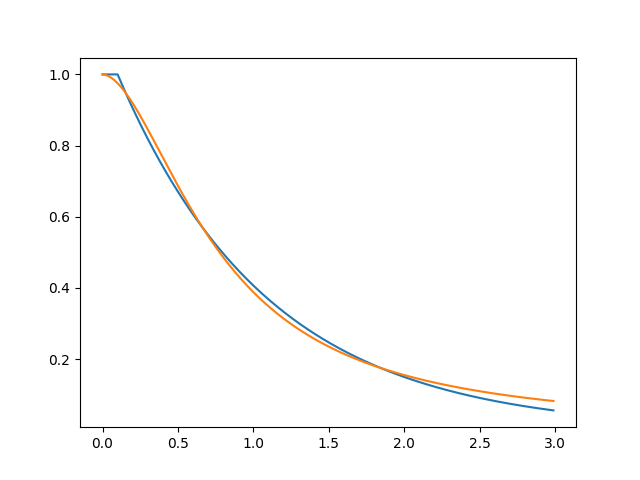

In [8]:
x = np.linspace(0, 3, 300)

y = (x>MIN_DIST) * np.exp(-x+MIN_DIST)
y[x<=MIN_DIST] = 1.0

function = lambda x, a, b: 1 / (1 + a*x**(2*b))

p , _ = optimize.curve_fit(function, x, y) 

a = p[0]
b = p[1] 
print("Hyperparameters a = " + str(a) + " and b = " + str(b))

x_p = np.arange(0,3,0.01)
y_p = np.exp(- (x_p-MIN_DIST) * ( (x_p - MIN_DIST) >=0 ) )
y_p2 = 1 / (1 + a*x_p**(2*b))

plt.figure()
plt.plot(x_p,y_p, label='Target')
plt.plot(x_p,y_p2, label='Fitted')

In [21]:
@numba.jit(nopython=True)
def clip(x,val=4.0):

    if x>val:
        return val
    elif x<-val:
        return -val
    else:
        return x
    
@numba.jit(nopython=True)
def update_attraction(x, y, a, b, dim, lr, P):
    dist = np.sum((x - y)**2)

    if dist>0.0:
        grad_coeff = 2*a*b*dist**(b-1.0) / (1 + a * dist**b)
    else:
        grad_coeff = 0.0


    for d in range(dim):
        mv = clip(grad_coeff * P * (x[0,d]-y[0,d]))  # * P[idx,idy]
        mv = mv * lr

        x[0,d] -= mv
        y[0,d] += mv
        
    return

@numba.jit(nopython=True)
def update_repulsion(x, y, a, b, dim, lr, P):
    dist = np.sum((x - y)**2)

    if dist>0.0:
        grad_coeff = 2 * repulsion_strength * b / ( (0.001+dist) * (1.0 + a * dist**b) )
    else:
        grad_coeff = 0


    for d in range(dim):
        #if grad_coeff > 0.0:
        #    grad = clip(grad_coeff  * (x[0,d]-y[0,d]))
        #    #* (1 - P[idx,idy])
        #else:
        #    grad = 0.0

        grad = clip(grad_coeff  * (x[0,d]-y[0,d]) * (1-P))
        mv = grad * lr

        x[0,d] += mv
        #y[0,d] -= mv

    
    
@numba.jit(nopython=True)
def one_step_in_a_set(emA, emH, idx, rows, columns, a, b, dim,
                   nA, n_points,
                   epochs_per_sample,
                   epoch_of_next_sample,
                   epochs_per_negative_sample,
                   epoch_of_next_negative_sample,
                   lr, epoch):
    
    if epoch_of_next_sample[idx] <= epoch:
        x_idx = rows[idx]
        y_idx = columns[idx]
        
        if x_idx < nA:
            x = emA[x_idx:x_idx+1,:]
        else:
            x = emH[x_idx-nA:x_idx-nA+1,:]
        
        if y_idx < nA:
            y = emA[y_idx:y_idx+1, :]
        else:
            y = emH[y_idx-nA:y_idx-nA+1,:]
            
        update_attraction(x, y, a, b, dim, lr, 1)
        
        epoch_of_next_sample[idx] += epochs_per_sample[idx]
        
        n_neg_samples = int(
                (epoch - epoch_of_next_negative_sample[idx]) / epochs_per_negative_sample[idx]
            )
        
        for i in range(n_neg_samples):
            y_idx = np.random.choice(n_points)
            
            if x_idx == y_idx:
                continue
            
            if y_idx < nA:
                y = emA[y_idx:y_idx+1, :]
            else:
                y = emH[y_idx-nA:y_idx-nA+1,:]
                
            update_repulsion(x, y, a, b, dim, lr, 0)
            
        epoch_of_next_negative_sample[idx] += (
                n_neg_samples * epochs_per_negative_sample[idx]
            )
            
            
            
    
    return 

@numba.jit(nopython=True, parallel=True)
def one_epoch_nsets(emCommon, embS,
                     rows, columns,
                     nCommon, n_points_,
                     Set, K_idx,
                     a, b, dim,
                     lr, epoch,
                     epochs_per_sample,
                     epoch_of_next_sample,
                     epochs_per_negative_sample,
                     epoch_of_next_negative_sample,
                     repulsion_strength=1.0):
    '''
    Set1 = 1 * np.ones(epochs_per_sample_1.shape[0])
    Set2 = 2 * np.ones(epochs_per_sample_2.shape[0])
    Set = np.random.permutation(np.concatenate((Set1,Set2)))
    '''
    
    for i in prange(len(Set)):
        idx = Set[i]
        one_step_in_a_set(emA=emCommon, emH=embS[idx], idx=K_idx[i], 
                              rows=rows[idx], columns=columns[idx], a=a, b=b, dim=dim,
                              nA=nCommon, n_points=n_points_[idx],
                              epochs_per_sample=epochs_per_sample[idx],
                              epoch_of_next_sample=epoch_of_next_sample[idx],
                              epochs_per_negative_sample=epochs_per_negative_sample[idx],
                              epoch_of_next_negative_sample=epoch_of_next_negative_sample[idx],
                              lr=lr, epoch=epoch)
    
    return 

from sklearn.decomposition import PCA

n_components = 2

pca = PCA(n_components = n_components)
init = pca.fit_transform(SETA)
embA = init.astype(np.float32).copy()
expansion = 10.0 / np.abs(embA).max()
embA = (embA * expansion).astype(np.float32)

emb_sets = []

print('before initi')

for i in range(n_SET):
    data = DATA[i]
    emb_i = pca.transform(data[nA:])
    emb_i = (emb_i * expansion).astype(np.float32)
    
    emb_sets.append(emb_i)
    
print('after init')

repulsion_strength=1.0

init_lr = 1.0

#SET_IDX
#K_IDX

print(len(EPOCH_OF_NEXT_NEGATIVE_SAMPLE))
print(EPOCH_OF_NEXT_NEGATIVE_SAMPLE[0].shape)

import timeit

for epoch in range(epochs):
    pass
    
    if epoch%20==0:
        print('epoch ', epoch, 'of ', epochs)
    #print('epoch ', epoch, 'of ', epochs)
    start = timeit.default_timer()
    
    lr = init_lr * (1.0 - float(epoch)/float(epochs))
    
    #'''
    one_epoch_nsets(emCommon=embA, embS=emb_sets,
                     rows=ROWS, columns=COLUMNS,
                     nCommon=nA, n_points_=N_DATA,
                     Set=SET_IDX, K_idx=K_IDX,
                     a=a, b=b, dim=n_components,
                     lr=lr, epoch=epoch,
                     epochs_per_sample=EPOCHS_PER_SAMPLE,
                     epoch_of_next_sample=EPOCH_OF_NEXT_SAMPLE,
                     epochs_per_negative_sample=EPOCHS_PER_NEGATIVE_SAMPLE,
                     epoch_of_next_negative_sample=EPOCH_OF_NEXT_NEGATIVE_SAMPLE,
                     repulsion_strength=repulsion_strength)
    #'''
    stop = timeit.default_timer()
    print('Time for epoch ', epoch, ': ', stop - start) 


before initi
after init
5
(934308,)
epoch  0 of  200


/home/ponir/pyTorch1.9/lib/python3.6/site-packages/numba/core/ir_utils.py:2119: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'columns' of function 'one_epoch_nsets'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-21-228e208a093b>", line 109:
@numba.jit(nopython=True, parallel=True)
def one_epoch_nsets(emCommon, embS,
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/home/ponir/pyTorch1.9/lib/python3.6/site-packages/numba/core/ir_utils.py:2119: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'embS' of function 'one_epoch_nsets'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-type

Time for epoch  0 :  4.513094198991894
Time for epoch  1 :  0.32840055201086216
Time for epoch  2 :  0.42915513399930205
Time for epoch  3 :  0.4684450609929627
Time for epoch  4 :  0.5342536340031074
Time for epoch  5 :  0.5478748630121117
Time for epoch  6 :  0.6013383459940087
Time for epoch  7 :  0.6106656430056319
Time for epoch  8 :  0.650115440992522
Time for epoch  9 :  0.6608493910025572
Time for epoch  10 :  0.690971403993899
Time for epoch  11 :  0.6995656910003163
Time for epoch  12 :  0.7023219640104799
Time for epoch  13 :  0.7110243150091264
Time for epoch  14 :  0.7138638960022945
Time for epoch  15 :  0.711568842001725
Time for epoch  16 :  0.7112031550059328
Time for epoch  17 :  0.7034291800082428
Time for epoch  18 :  0.7144289810094051
Time for epoch  19 :  0.7223509370087413
epoch  20 of  200
Time for epoch  20 :  0.725985890996526
Time for epoch  21 :  0.7231563930108678
Time for epoch  22 :  0.7226726539956871
Time for epoch  23 :  0.7240528000111226
Time for ep

Time for epoch  195 :  0.7445283870038111
Time for epoch  196 :  0.7339720490126638
Time for epoch  197 :  0.7345106529974146
Time for epoch  198 :  0.7350414710090263
Time for epoch  199 :  0.7357585300051142


<IPython.core.display.Javascript object>


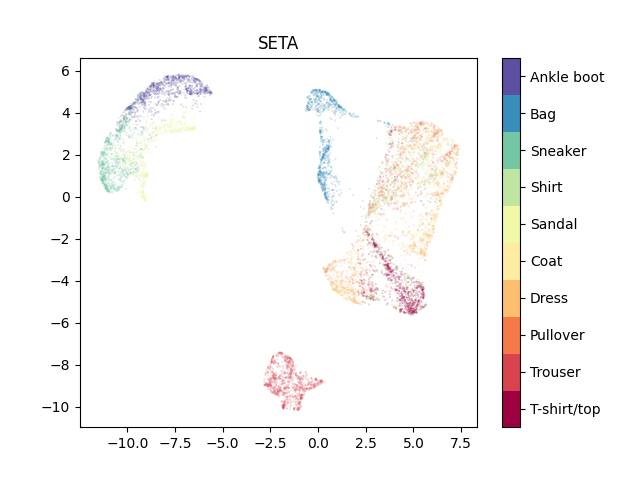

(10000, 2)


<IPython.core.display.Javascript object>


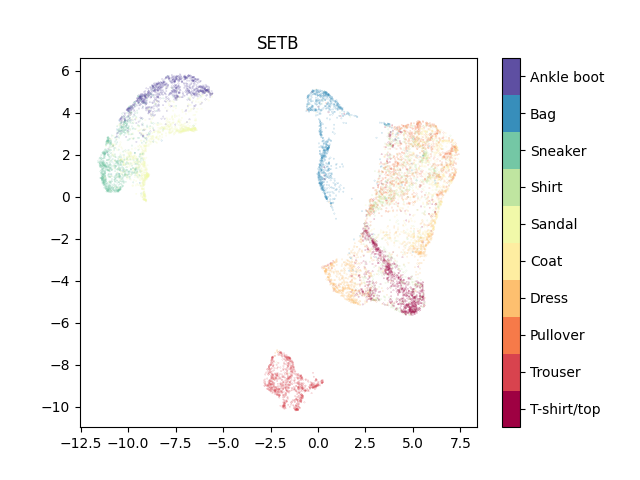

<IPython.core.display.Javascript object>


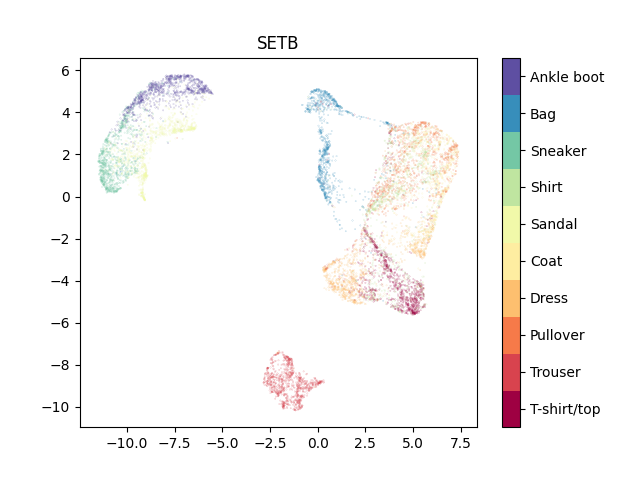

<IPython.core.display.Javascript object>


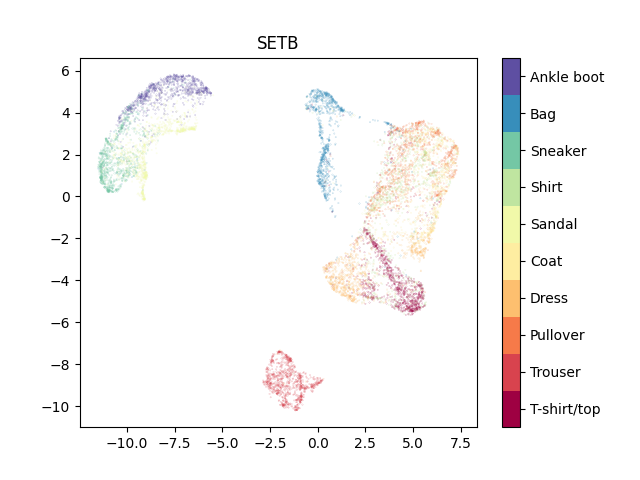

<IPython.core.display.Javascript object>


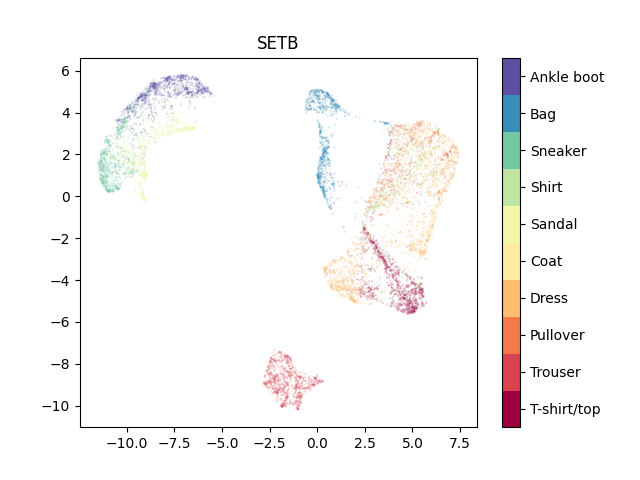

<IPython.core.display.Javascript object>


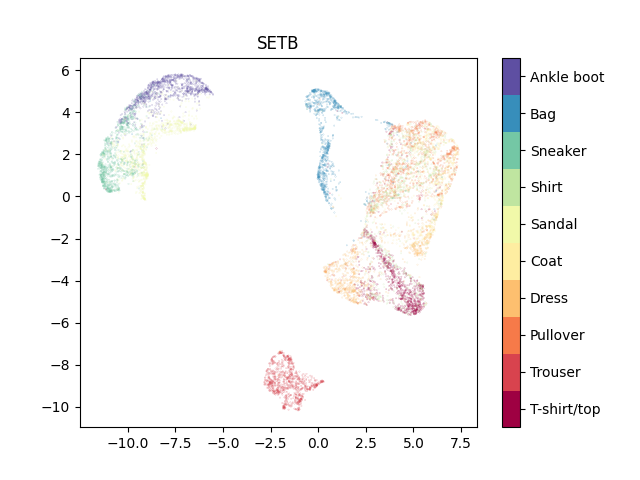

In [22]:
%matplotlib notebook

plt.figure()
plt.title('SETA')
print(embA.shape)
plt.scatter(embA[:,0], embA[:,1], c=y_SETA, s=0.01, cmap='Spectral')
cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)

for i in range(n_SET):

    plt.figure()
    plt.title('SETB')
    embB = emb_sets[i]
    y_embB = y_SETS[i]
    plt.scatter(embB[:,0], embB[:,1], c=y_embB, s=0.01, cmap='Spectral')
    cbar = plt.colorbar(boundaries=np.arange(11)-0.5)
    cbar.set_ticks(np.arange(10))
    cbar.set_ticklabels(classes)




array([array([0, 0, 0, ..., 0, 0, 0]), array([1, 1, 1, ..., 1, 1, 1]),
       array([2, 2, 2, ..., 2, 2, 2]), array([3, 3, 3, ..., 3, 3, 3]),
       array([4, 4, 4, ..., 4, 4, 4])], dtype=object)

(4671274,)

In [ ]:
emb_sets_tuned = np.array(emb_sets)

with open('FMNIST_Aligned_NE_5_SETS.npy', 'wb') as f:
    np.save(f, embA)
    np.save(f, emb_sets_tuned)